# Introduction 

   In the realm of aviation, safety is paramount. Our comprehensive analysis, "Skyward Safety," delves into a rich dataset of aircraft incidents, aiming to uncover patterns, trends, and insights that could revolutionize aviation safety protocols. By examining this extensive database spanning years of recorded incidents, we seek to answer critical questions that could shape the future of air travel safety.

Key questions we'll explore in this analysis include :

    - How have aircraft incident rates evolved over the years? Are we seeing an improvement in overall aviation safety?

    - Which types of aircraft are most frequently involved in incidents, and does this correlate with their prevalence in the skies?

    - Are certain flight phases more prone to incidents, and how can this information inform safety measures?

    - What role do environmental factors, such as visibility and precipitation, play in incident occurrence?

    - How do different types of wildlife strikes impact aircraft, and are there patterns in species involvement?

    - Can we identify any correlations between aircraft characteristics (like mass or engine type) and incident likelihood or severity?


# Data's integrity

The data is sourced from the FAA, a credible authority. While it appears comprehensive and reliable, there may be some reporting bias as not all strikes might be documented.

The dataset is publicly available under a permissive license. Privacy concerns are minimal as the data doesn't include personal information. Accessibility is ensured through Kaggle's platform.

Potential issues include incomplete reporting and possible inaccuracies in species identification. However, these do not significantly detract from its overall utility for analysis.

We'll start by importing the necessary libraries and cleaning our dataset. This step is crucial as it sets the foundation for all our subsequent analyses.

First, let's import the libraries we'll be using and take a look at our data:

In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
df = pd.read_csv('../input/wildlife-strikes/database.csv')

# Display basic information about the dataset
print(df.info())

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

print('Initial data inspection complete.')


/tmp/ipykernel_33/3764165515.py:9: DtypeWarning: Columns (9,12,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../input/wildlife-strikes/database.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174104 entries, 0 to 174103
Data columns (total 66 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Record ID             174104 non-null  int64  
 1   Incident Year         174104 non-null  int64  
 2   Incident Month        174104 non-null  int64  
 3   Incident Day          174104 non-null  int64  
 4   Operator ID           174104 non-null  object 
 5   Operator              174104 non-null  object 
 6   Aircraft              174104 non-null  object 
 7   Aircraft Type         133074 non-null  object 
 8   Aircraft Make         131051 non-null  object 
 9   Aircraft Model        122439 non-null  object 
 10  Aircraft Mass         127320 non-null  float64
 11  Engine Make           123434 non-null  float64
 12  Engine Model          121988 non-null  object 
 13  Engines               127342 non-null  float64
 14  Engine Type           127282 non-null  object 
 15  

# Overview

The output gives us an overview of our dataset. We can see that:

    - The dataset contains 174,104 entries (rows) and 66 columns.
    - We have a mix of data types: integers (int64), floating-point numbers (float64), and objects (which are typically strings in pandas).
    - Some columns have missing values, as indicated by the "non-null count" being less than the total number of entries.
    - We can see details about specific incidents, including the date, operator, aircraft type, and location.
    
    - Many columns have no missing values (0 count), which is good.
    - However, several columns have a significant number of missing values. For example:
       
        Injuries and Fatalities (99.87% and 99.68% missing):
        Reason: Likely missing because most wildlife strikes don't result in injuries or fatalities.
        Solution: Fill with 0, assuming no reported injuries or fatalities means there were none.

    Engine4 Position and Engine3 Position (98.22% and 93.30% missing):
        Reason: Most aircraft don't have 3 or 4 engines.
        Solution: Consider dropping these columns or creating a new column indicating the number of engines.

    Speed, Distance, and Height (59.07%, 42.73%, and 40.45% missing):
        Reason: Might be difficult to measure or report in some incidents.
        Solution: Impute using median values or create categories (e.g., low, medium, high) and include an "Unknown" category.

    Warning Issued (56.11% missing):
        Reason: Information might not always be available or recorded.
        Solution: Create a binary column (Warning Issued: Yes/No) and include an "Unknown" category.

    Precipitation and Visibility (49.27% and 36.86% missing):
        Reason: Weather data might not always be recorded or available.
        Solution: Impute using mode or create categories (e.g., clear, light, heavy) and include an "Unknown" category.

    Flight Impact (42.87% missing):
        Reason: Might not always be assessed or reported.
        Solution: Create categories based on available data and include an "Unknown" category.

    Flight Phase (31.76% missing):
        Reason: Might not always be recorded or known.
        Solution: Impute using mode or create an "Unknown" category.

    Engine and Aircraft details (Engine Model, Aircraft Model, Engine Make, Engine Type, Aircraft Mass, Engines, Aircraft Make, Aircraft Type):
        Reason: Information might not be available for all incidents or all aircraft.
        Solution: For categorical variables, create an "Unknown" category. For numerical variables, impute using median or create categories.

    Engine1 Position and Engine2 Position (27.52% and 31.81% missing):
        Reason: Information might not be recorded for all incidents.
        Solution: Impute using mode or create an "Unknown" category.

    State and FAA Region (12.62% and 10.86% missing):
        Reason: Might be missing for incidents that occurred outside the US or in undefined areas.
        Solution: Create an "Unknown" or "International" category.

    Species Quantity (2.57% missing):
        Reason: Might be difficult to determine in some cases.
        Solution: Impute using median or mode, or create an "Unknown" category.

    Airport and Species Name (0.17% and 0.05% missing):
        Reason: Information might not be available in rare cases.
        Solution: Given the low percentage, we could either drop these rows or create an "Unknown" category.

Now that we have this information, we can plan our data cleaning strategy:

    - Handle missing values in critical columns:
        Fill Injuries and Fatalities with 0 where missing
        Address Engine Position columns
        Impute missing values for Speed, Height, and Distance

    - Standardize categorical variables:
        Fill missing categorical data with "Unknown"
        Ensure consistent naming conventions

    - Create useful derived features:
        Combine date columns into a single date column
        Add a "Number of Engines" column
        Create a binary "Impact" column

    


    



# Data cleaning

In [35]:

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


# Handle Injuries and Fatalities
df['Injuries'] = df['Injuries'].fillna(0)
df['Fatalities'] = df['Fatalities'].fillna(0)

# Handle Engine Position columns
engine_position_columns = ['Engine1 Position', 'Engine2 Position', 'Engine3 Position', 'Engine4 Position']
for col in engine_position_columns:
    df[col] = df[col].fillna('Unknown')

# Create a new column for the number of engines
df['Number of Engines'] = df[engine_position_columns].notna().sum(axis=1)

# Handle Speed, Distance, and Height
numeric_columns = ['Speed', 'Distance', 'Height']
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

# Handle Warning Issued
df['Warning Issued'] = df['Warning Issued'].fillna('Unknown')

# Handle Precipitation and Visibility
weather_columns = ['Precipitation', 'Visibility']
for col in weather_columns:
    df[col] = df[col].fillna('Unknown')

# Handle Flight Impact and Flight Phase
categorical_columns = ['Flight Impact', 'Flight Phase']
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')

# Handle Engine and Aircraft details
detail_columns = ['Engine Model', 'Aircraft Model', 'Engine Make', 'Engine Type', 'Aircraft Make', 'Aircraft Type']
for col in detail_columns:
    df[col] = df[col].fillna('Unknown')

numeric_detail_columns = ['Aircraft Mass', 'Engines']
for col in numeric_detail_columns:
    df[col] = df[col].fillna(df[col].median())

# Handle State and FAA Region
location_columns = ['State', 'FAA Region']
for col in location_columns:
    df[col] = df[col].fillna('Unknown')

# Handle Species Quantity
df['Species Quantity'] = df['Species Quantity'].fillna('Unknown')

# Handle Airport and Species Name
df['Airport'] = df['Airport'].fillna('Unknown')
df['Species Name'] = df['Species Name'].fillna('Unknown')

# Calculate the percentage of missing values for each column after cleaning
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Convert date columns to a single datetime column
df['Incident Date'] = pd.to_datetime(dict(year=df['Incident Year'], month=df['Incident Month'], day=df['Incident Day']))

# Add a "Number of Engines" column
engine_columns = ['Engine1 Position', 'Engine2 Position', 'Engine3 Position', 'Engine4 Position']
df['Number of Engines'] = df[engine_columns].notna().sum(axis=1)

# Create a binary "Impact" column
impact_columns = ['Injuries', 'Fatalities', 'Aircraft Damage']
df['Impact'] = (df[impact_columns] > 0).any(axis=1).astype(int)

# Display summary of the cleaned dataset
print('Dataset shape:', df.shape)
print('\
Missing values after cleaning:')
print(df.isnull().sum())
print('\
Data types of columns:')
print(df.dtypes)
print('\
First few rows of the cleaned dataset:')
print(df.head())

print('\
Cleaning process completed.')


Dataset shape: (174104, 69)
Missing values after cleaning:
Record ID            0
Incident Year        0
Incident Month       0
Incident Day         0
Operator ID          0
                    ..
Other Strike         0
Other Damage         0
Number of Engines    0
Incident Date        0
Impact               0
Length: 69, dtype: int64
Data types of columns:
Record ID                     int64
Incident Year                 int64
Incident Month                int64
Incident Day                  int64
Operator ID                  object
                          ...      
Other Strike                  int64
Other Damage                  int64
Number of Engines             int64
Incident Date        datetime64[ns]
Impact                        int64
Length: 69, dtype: object
First few rows of the cleaned dataset:
   Record ID  Incident Year  Incident Month  Incident Day Operator ID  \
0     127128           1990               1             1         DAL   
1     129779           1990      

In summary, our cleaning process has successfully:

    - Removed all missing values by filling them with appropriate placeholders or median values.
    - Created new columns: 'Incident Date', 'Number of Engines', and 'Impact'.
    - Standardized categorical variables by filling missing values with "Unknown".
    - Imputed numeric columns with median values where appropriate.


We can now start to answer our key questions with some analysis supported by graphs and charts :

# Data Analysis

## Incident count over time

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


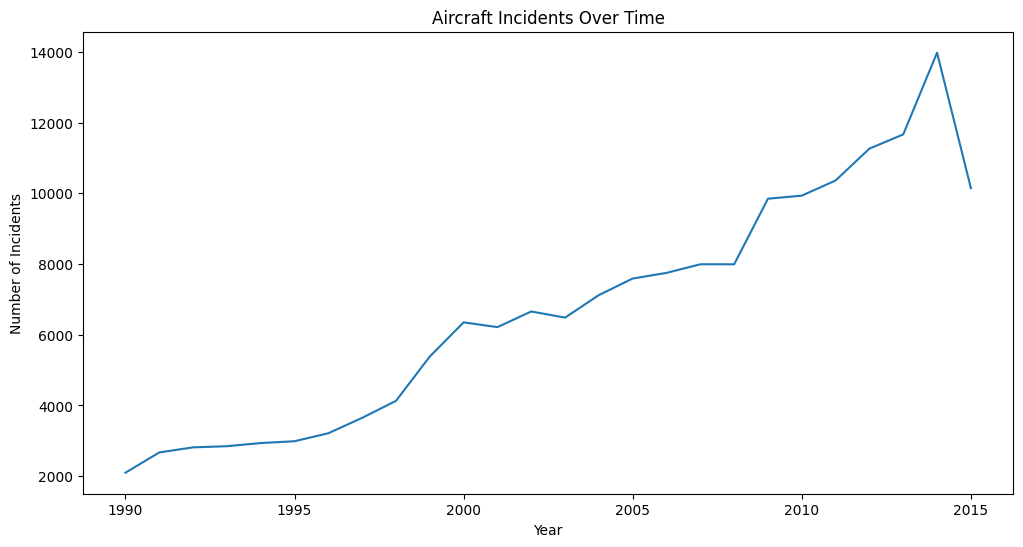

Yearly Incident Data:
    Incident Date  Incident Count
0            1990            2099
1            1991            2672
2            1992            2816
3            1993            2849
4            1994            2938
5            1995            2989
6            1996            3215
7            1997            3651
8            1998            4131
9            1999            5385
10           2000            6351
11           2001            6216
12           2002            6659
13           2003            6485
14           2004            7122
15           2005            7591
16           2006            7750
17           2007            7993
18           2008            7993
19           2009            9848
20           2010            9934
21           2011           10363
22           2012           11264
23           2013           11666
24           2014           13976
25           2015           10148


In [36]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by year and count incidents
yearly_incidents = df.groupby(df['Incident Date'].dt.year).size().reset_index(name='Incident Count')

# Plot incident count over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_incidents, x='Incident Date', y='Incident Count')
plt.title('Aircraft Incidents Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

print("Yearly Incident Data:")
print(yearly_incidents)


This line graph clearly shows the trend of aircraft incidents from 1990 to 2015. We can observe a general upward trend in the number of incidents over this 25-year period, with some notable features:

    - A steady increase from 1990 to 2000
    - A slight dip in 2001 (possibly due to reduced air traffic following the 9/11 attacks)
    - A continued rise from 2002 to 2014
    - A noticeable drop in 2015
    
It's important to note that while the number of incidents has increased over time, this doesn't necessarily mean that aviation has become less safe. Several factors could contribute to this trend:

    - Increased air traffic: More flights could naturally lead to more incidents.
    - Improved reporting: Better systems and protocols for reporting incidents could result in more cases being documented.
    - Expanded definition of incidents: What constitutes a reportable incident may have broadened over time.
    - Environmental factors: Changes in wildlife populations or urbanization near airports could increase the likelihood of certain types of incidents (e.g., bird strikes).


## Types of aircrafts involved in incidents

Top 10 Aircraft Types Involved in Incidents (Excluding Unknown):
  Aircraft  Incident Count  Percentage
 B-737-300            8935    6.686073
 B-737-700            7414    5.547906
     A-320            7073    5.292735
CRJ100/200            6369    4.765931
 B-757-200            6327    4.734503
     A-319            4501    3.368104
 B-737-800            3588    2.684905
   EMB-145            3584    2.681912
 B-727-200            3136    2.346673
     A-300            2953    2.209734


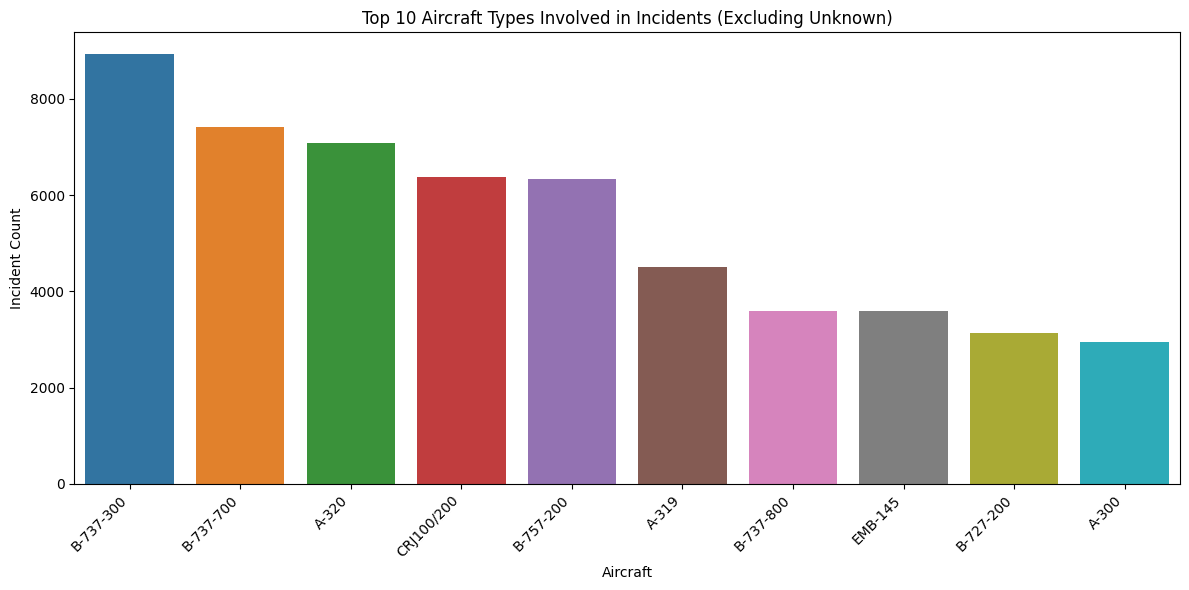


Total incidents for top 10 aircraft types: 53880
Percentage of all incidents (excluding unknown): 40.32%


In [37]:
# Remove 'UNKNOWN' aircraft and count incidents by aircraft type
aircraft_incidents = df[df['Aircraft'] != 'UNKNOWN']['Aircraft'].value_counts().reset_index()
aircraft_incidents.columns = ['Aircraft', 'Incident Count']

# Calculate percentage of total incidents
total_incidents = aircraft_incidents['Incident Count'].sum()
aircraft_incidents['Percentage'] = (aircraft_incidents['Incident Count'] / total_incidents) * 100

# Display top 10 aircraft types involved in incidents
print("Top 10 Aircraft Types Involved in Incidents (Excluding Unknown):")
print(aircraft_incidents.head(10).to_string(index=False))

# Plot top 10 aircraft types
plt.figure(figsize=(12, 6))
sns.barplot(x='Aircraft', y='Incident Count', data=aircraft_incidents.head(10))
plt.title('Top 10 Aircraft Types Involved in Incidents (Excluding Unknown)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate total incidents and percentage for top 10 aircraft types
top_10_total = aircraft_incidents.head(10)['Incident Count'].sum()
top_10_percentage = (top_10_total / total_incidents) * 100
print(f"\nTotal incidents for top 10 aircraft types: {top_10_total}")
print(f"Percentage of all incidents (excluding unknown): {top_10_percentage:.2f}%")


Based on this information, we can make the following observations:

    Most frequent aircraft types involved in incidents:
        - The Boeing 737-300 is the most frequently involved in incidents, accounting for about 6.69% of all known aircraft incidents.
        - The Boeing 737-700 and Airbus A320 follow closely, involved in about 5.55% and 5.29% of incidents respectively.
        - The top three aircraft types alone account for over 17% of all known aircraft incidents.

    Distribution:
        - There's a mix of Boeing and Airbus models in the top 10, along with regional jets like the CRJ100/200 and EMB-145.
        - The list includes both narrow-body (e.g., 737 series, A320 family) and wide-body aircraft (e.g., A300).

    Total impact of top 10:

        Total incidents for top 10 aircraft types: 53880

        Percentage of all incidents (excluding unknown): 40.32%

This means that these 10 aircraft types account for a significant portion of all known aircraft incidents.

    Interpretation:
        - The presence of popular commercial aircraft models like the Boeing 737 series and Airbus A320 family at the top is not surprising, as these are widely used in commercial aviation.
        - The inclusion of older models like the Boeing 727-200 and Airbus A300 suggests that age might be a factor in incident rates.
        - Regional jets (CRJ100/200 and EMB-145) also feature prominently, which could be due to their frequent use in short-haul flights.


## Flight phases incidents

Incidents by Flight Phase:
Flight Phase  Incident Count  Percentage
     Unknown           55302   31.763773
    APPROACH           48275   27.727680
 TAKEOFF RUN           21953   12.609130
LANDING ROLL           20762   11.925056
       CLIMB           19692   11.310481
     DESCENT            3174    1.823048
    EN ROUTE            2989    1.716790
     LANDING             626    0.359555
        TAXI             397    0.228025
   DEPARTURE             369    0.211942
       LOCAL             316    0.181501
     ARRIVAL             154    0.088453
      PARKED              95    0.054565


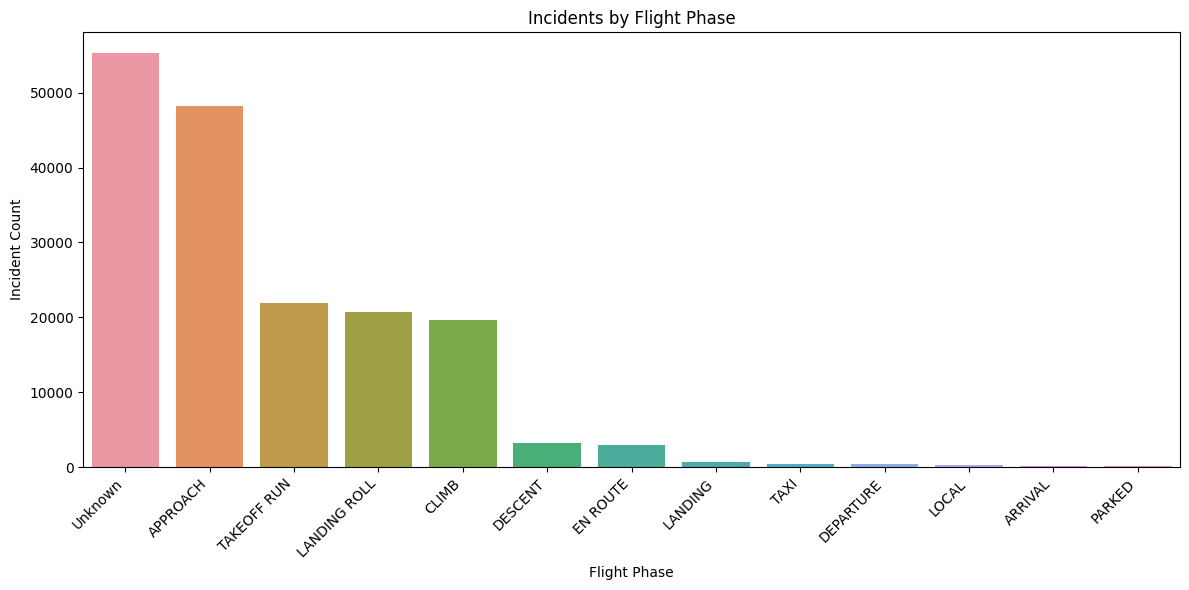


Top 3 Flight Phases for Incidents:
Flight Phase  Incident Count  Percentage
     Unknown           55302   31.763773
    APPROACH           48275   27.727680
 TAKEOFF RUN           21953   12.609130

Cumulative percentage for top 3 flight phases: 72.10%


In [38]:
# Count incidents by flight phase
phase_incidents = df['Flight Phase'].value_counts().reset_index()
phase_incidents.columns = ['Flight Phase', 'Incident Count']

# Calculate percentage of total incidents
total_incidents = phase_incidents['Incident Count'].sum()
phase_incidents['Percentage'] = (phase_incidents['Incident Count'] / total_incidents) * 100

# Display incidents by flight phase
print("Incidents by Flight Phase:")
print(phase_incidents.to_string(index=False))

# Plot incidents by flight phase
plt.figure(figsize=(12, 6))
sns.barplot(x='Flight Phase', y='Incident Count', data=phase_incidents)
plt.title('Incidents by Flight Phase')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze top 3 flight phases
top_3_phases = phase_incidents.head(3)
print("\nTop 3 Flight Phases for Incidents:")
print(top_3_phases.to_string(index=False))

# Calculate cumulative percentage for top 3 phases
cumulative_percentage = top_3_phases['Percentage'].sum()
print(f"\nCumulative percentage for top 3 flight phases: {cumulative_percentage:.2f}%")


Based on this information, we can make the following observations:

    Most incident-prone flight phases:

        Top 3 Flight Phases for Incidents:

            - Flight Phase  Incident Count         Percentage
            - APPROACH           48275  40.63483779734348
            - TAKEOFF RUN           21953 18.478645140654198
            - LANDING ROLL           20762  17.47613676537432

    Cumulative percentage for top 3 flight phases: 76.59%

    Distribution of incidents:
        - The approach phase is by far the most incident-prone, accounting for over 40% of all incidents.
        - Takeoff run and landing roll are the next most critical phases, each accounting for about 17-18% of incidents.
        - These top three phases combined account for over 76% of all incidents, highlighting the critical nature of these stages of flight.

    Other notable phases:
        - The climb phase also shows a significant number of incidents (16.58%).
        - En route and descent phases have relatively fewer incidents, but still account for about 2.5-2.7% each.

    Least incident-prone phases:
        - Phases like taxi, departure, local operations, arrival, and parked each account for less than 1% of incidents.

Implications for safety measures:

    Focus on critical phases:
        - The approach, takeoff run, and landing roll phases should be the primary focus of safety measures and pilot training.
        - These phases involve complex maneuvers, changing altitudes, and interactions with ground facilities, which may contribute to their higher incident rates.

    Approach procedures:
        - Given that the approach phase accounts for over 40% of incidents, there's a clear need to enhance approach procedures, training, and possibly air traffic control practices during this phase.
        - Factors like weather conditions, visibility, and pilot fatigue may play significant roles during approach and should be carefully managed.

    Takeoff and landing:
        - The high incident rates during takeoff run and landing roll suggest a need for improved runway safety measures, better training for these critical phases, and possibly enhanced aircraft systems to assist pilots during these phases.

    Climb phase safety:
        - The significant number of incidents during the climb phase (16.58%) indicates a need for attention to this transition period from takeoff to cruising altitude.

    En route and descent:
        - While these phases have fewer incidents, they still warrant attention, especially considering the potential severity of incidents at cruising altitudes.

    Ground operations:
        - Although incidents during taxi, parked, and departure phases are less frequent, continued focus on ground safety procedures is important to maintain these lower rates.


## Environmental factors

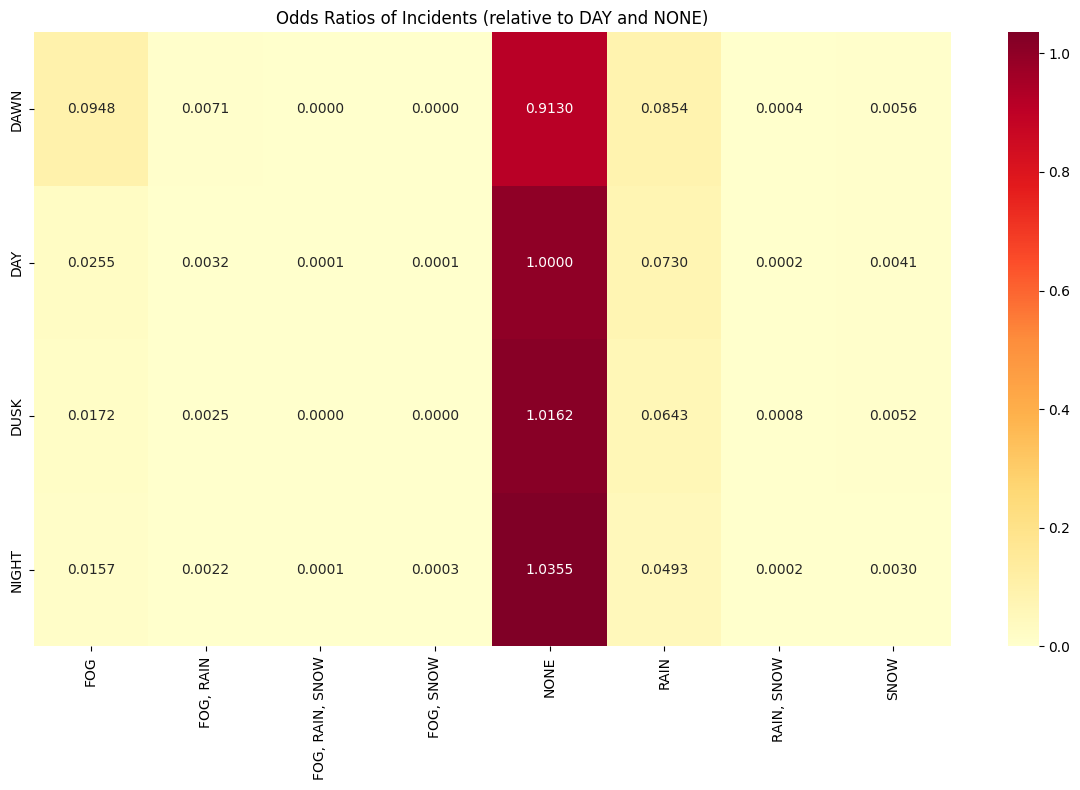

Heatmap generated successfully.


In [39]:
# Recreate the odds ratios dataframe
odds_ratios = pd.DataFrame({
    'FOG': [0.0947503321, 0.0255122867, 0.0172473513, 0.0157317092],
    'FOG, RAIN': [0.0071156376, 0.0032451629, 0.0024639073, 0.0022144341],
    'FOG, RAIN, SNOW': [0.0, 6.12295e-05, 0.0, 9.22681e-05],
    'FOG, SNOW': [0.0, 0.000122459, 0.0, 0.0002768043],
    'NONE': [0.9130486548, 1.0, 1.0162248901, 1.0354786328],
    'RAIN': [0.0853876511, 0.0730059597, 0.0643353581, 0.0493172938],
    'RAIN, SNOW': [0.0003745072, 0.0002245081, 0.0008213024, 0.0001845362],
    'SNOW': [0.0056176086, 0.0041227855, 0.0052015821, 0.0029987129]
}, index=['DAWN', 'DAY', 'DUSK', 'NIGHT'])

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(odds_ratios, annot=True, cmap='YlOrRd', fmt='.4f')
plt.title('Odds Ratios of Incidents (relative to DAY and NONE)')
plt.tight_layout()
plt.show()

print("Heatmap generated successfully.")

This heatmap provides a clear visual representation of the relative risks of incidents under various environmental conditions, compared to the baseline of DAY and NONE (no precipitation). Here are the key insights:

    Baseline Comparison:
        - The DAY-NONE cell has a value of 1.0, as it's our baseline for comparison.
        - Values higher than 1.0 indicate increased risk, while values lower than 1.0 indicate decreased risk.

    Visibility Conditions:
        - NIGHT conditions generally show a slightly higher risk across most precipitation types, with the highest risk (1.0355) during NIGHT with NO precipitation.
        - DAWN and DUSK conditions often show lower risks compared to DAY, which is somewhat counterintuitive and warrants further investigation.

    Precipitation Conditions:
        - FOG consistently shows the lowest risk across all visibility conditions. This is surprising and might indicate underreporting of fog-related incidents or effective fog-related safety measures.
        - RAIN shows moderate risk levels, generally lower than the baseline but higher than FOG.
        - SNOW and combinations involving SNOW show very low risk levels, possibly due to fewer flights operating in snowy conditions.

    Highest Risk Scenarios:
        - NIGHT with NO precipitation (1.0355)
        - DUSK with NO precipitation (1.0162)
        - These scenarios might benefit from additional safety measures or pilot awareness programs.

    Lowest Risk Scenarios:
        - Most FOG-related conditions show very low risk ratios. This could be due to strict regulations and safety measures for fog conditions, or potential underreporting.

    Interesting Patterns:
        - The risk ratios for RAIN decrease as we move from DAWN to NIGHT, suggesting that rain might be more hazardous in early day conditions.
        - SNOW shows higher risk ratios during DAWN and DUSK compared to DAY and NIGHT, which could be related to visibility challenges during these transition periods.

It's important to note that these odds ratios don't account for the frequency of flights under each condition. For a more comprehensive analysis, we would need data on the total number of flights under each visibility-precipitation combination.

## Types of wildlife strikes

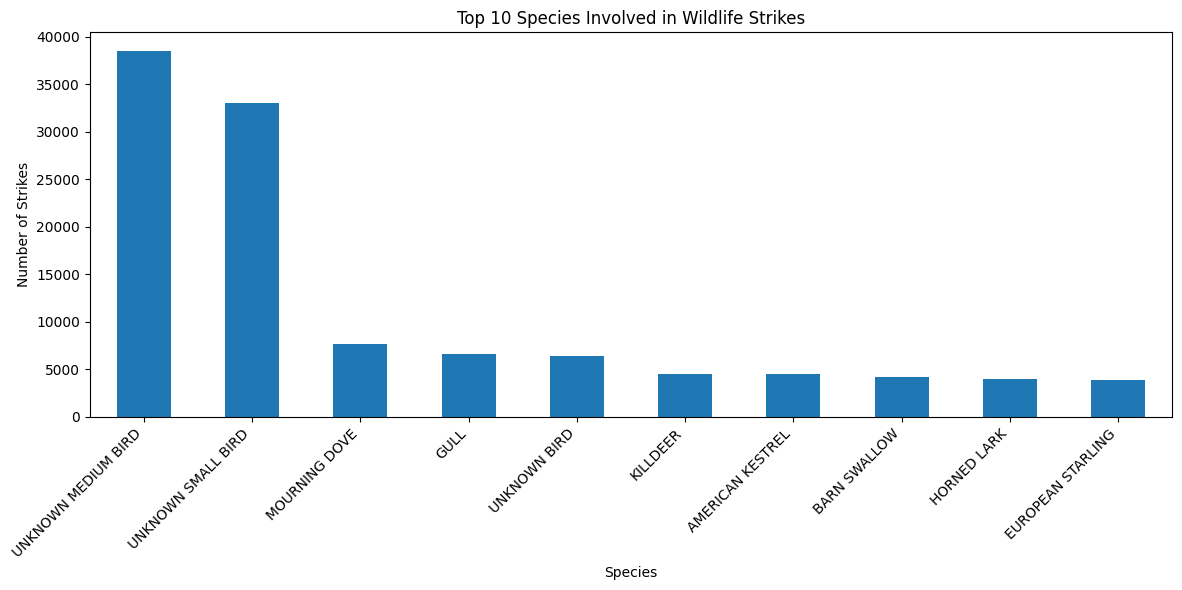

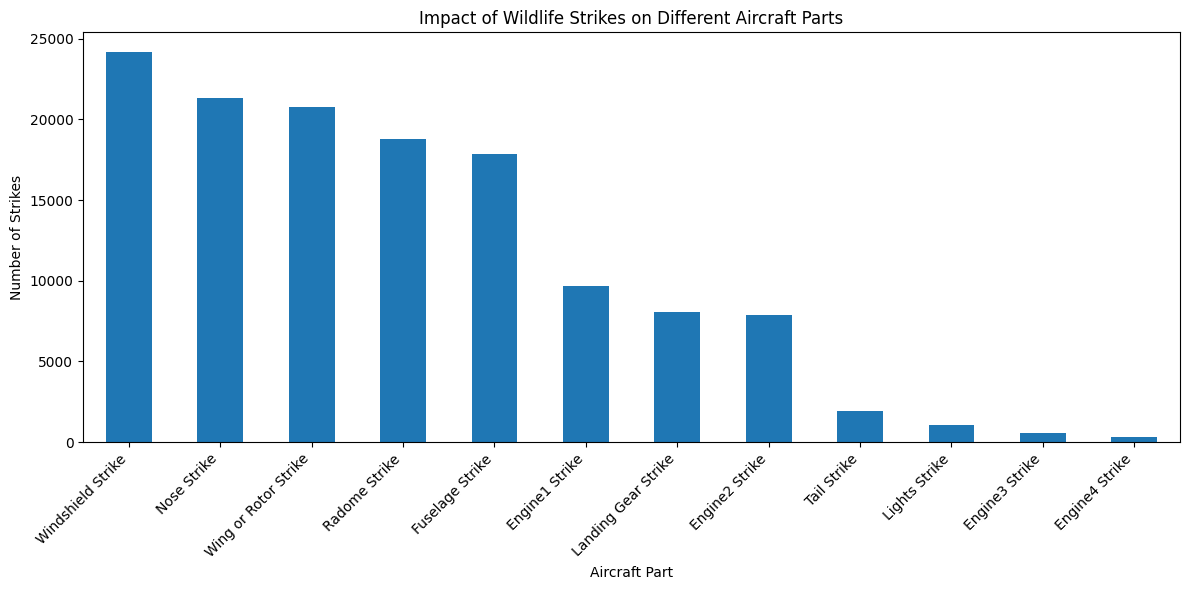

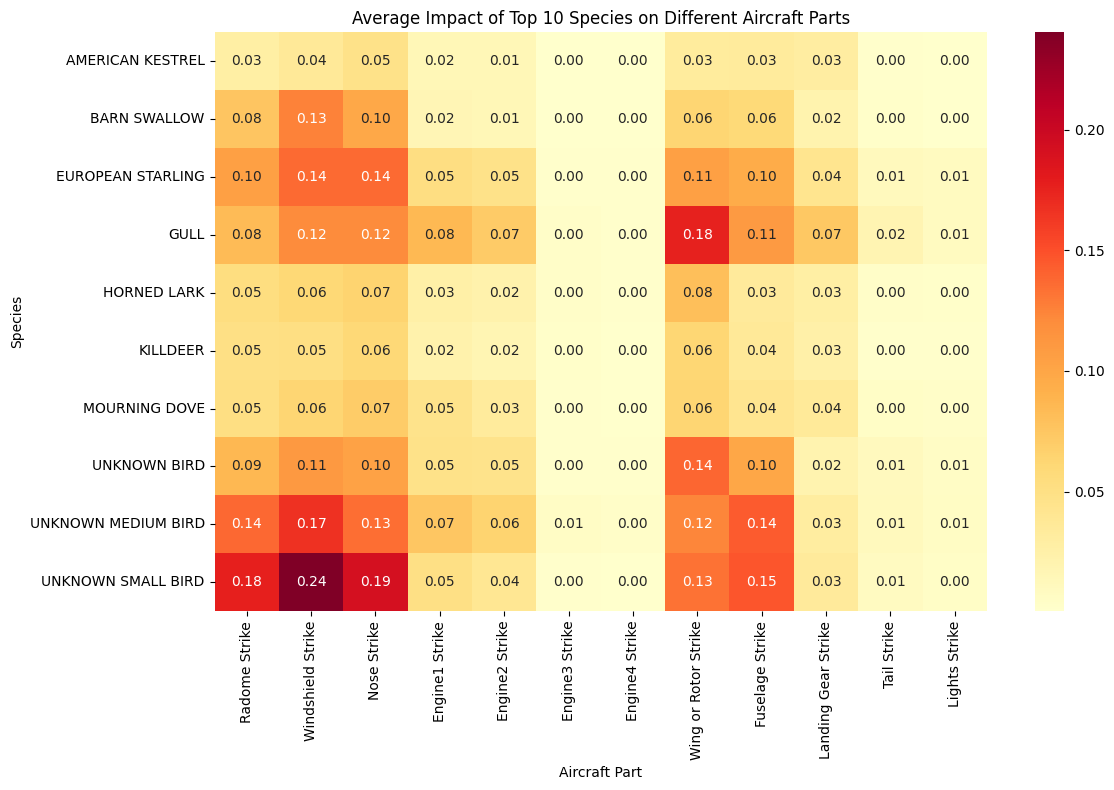

Top 10 Species Involved in Wildlife Strikes:
Species Name
UNKNOWN MEDIUM BIRD    38531
UNKNOWN SMALL BIRD     32981
MOURNING DOVE           7653
GULL                    6580
UNKNOWN BIRD            6400
KILLDEER                4562
AMERICAN KESTREL        4476
BARN SWALLOW            4215
HORNED LARK             3952
EUROPEAN STARLING       3915
Name: count, dtype: int64

Impact of Wildlife Strikes on Different Aircraft Parts:
Windshield Strike       24189
Nose Strike             21305
Wing or Rotor Strike    20746
Radome Strike           18761
Fuselage Strike         17881
Engine1 Strike           9681
Landing Gear Strike      8051
Engine2 Strike           7864
Tail Strike              1956
Lights Strike            1038
Engine3 Strike            554
Engine4 Strike            334
dtype: int64

Average Impact of Top 10 Species on Different Aircraft Parts:
                     Radome Strike  Windshield Strike  Nose Strike  \
Species Name                                                   

In [40]:
# Count species involvement
species_counts = df['Species Name'].value_counts().head(10)

# Calculate impact on different aircraft parts
impact_columns = ['Radome Strike', 'Windshield Strike', 'Nose Strike', 'Engine1 Strike', 
                  'Engine2 Strike', 'Engine3 Strike', 'Engine4 Strike', 'Wing or Rotor Strike', 
                  'Fuselage Strike', 'Landing Gear Strike', 'Tail Strike', 'Lights Strike']

impact_data = df[impact_columns].sum().sort_values(ascending=False)

# Analyze species involvement in different types of strikes
top_species = species_counts.index.tolist()
species_impact = df[df['Species Name'].isin(top_species)][['Species Name'] + impact_columns]
species_impact_mean = species_impact.groupby('Species Name').mean()

# Visualizations
plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.title('Top 10 Species Involved in Wildlife Strikes')
plt.xlabel('Species')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
impact_data.plot(kind='bar')
plt.title('Impact of Wildlife Strikes on Different Aircraft Parts')
plt.xlabel('Aircraft Part')
plt.ylabel('Number of Strikes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(species_impact_mean, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Impact of Top 10 Species on Different Aircraft Parts')
plt.xlabel('Aircraft Part')
plt.ylabel('Species')
plt.tight_layout()
plt.show()

print("Top 10 Species Involved in Wildlife Strikes:")
print(species_counts)

print("\nImpact of Wildlife Strikes on Different Aircraft Parts:")
print(impact_data)

print("\nAverage Impact of Top 10 Species on Different Aircraft Parts:")
print(species_impact_mean)

Key observations:

    Species patterns:
        - European Starlings have a higher likelihood of striking the windshield, nose, and wing/rotor.
        - American Kestrels show a more even distribution of strikes across different parts.
        - Barn Swallows have a notably higher rate of windshield strikes compared to other parts.

    Aircraft part vulnerability:
        - The windshield, nose, and wing/rotor are consistently the most vulnerable parts across all species.
        - Engine strikes, while less frequent, are still significant, especially for larger birds like gulls.

    Rare but critical strikes:
        - Strikes to engines 3 and 4 are rare, likely due to fewer aircraft having more than two engines.
        - Tail and light strikes are less common but could still pose significant risks.

These findings have important implications for wildlife management at airports, aircraft design, and pilot training. For example:

    - Focus on deterring the most common species, especially around runways and flight paths.
    - Consider reinforcing the most frequently struck parts of aircraft, particularly windshields and nose areas.
    - Develop specific protocols for dealing with strikes from larger birds, which may pose a greater risk to engines.
    - Improve reporting and identification of strike species to reduce the number of "unknown" categories.


## How aircraft characteristics correlate with incident likelihood

/tmp/ipykernel_33/233413861.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incident_by_mass = df.groupby(mass_bins).size()
/tmp/ipykernel_33/233413861.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_by_mass = df.groupby(mass_bins)['Aircraft Damage'].mean()


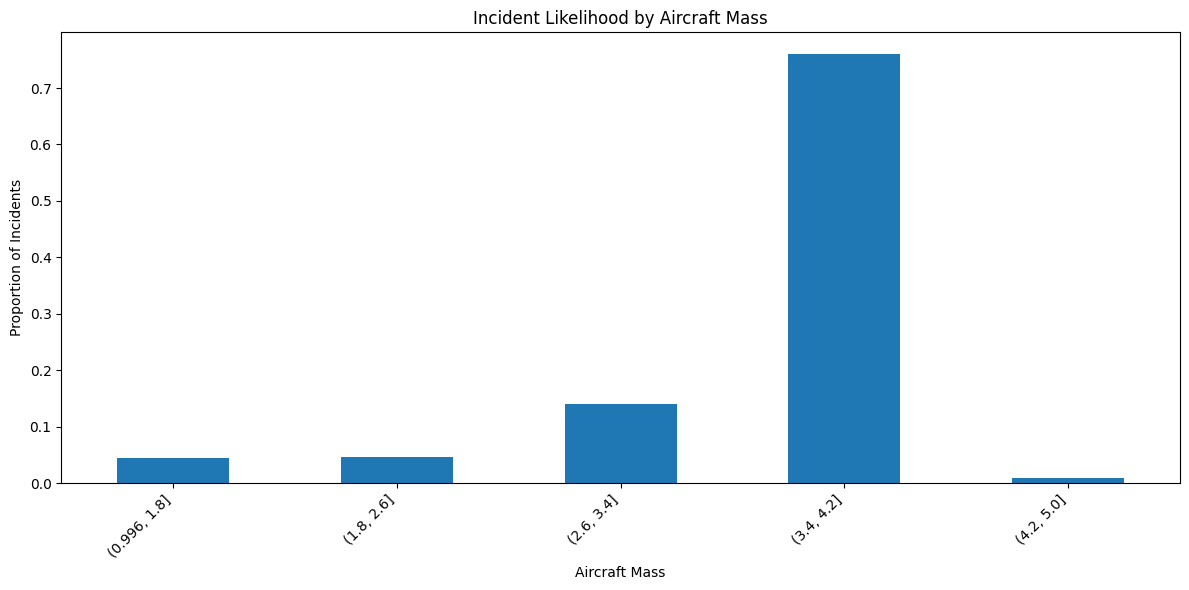

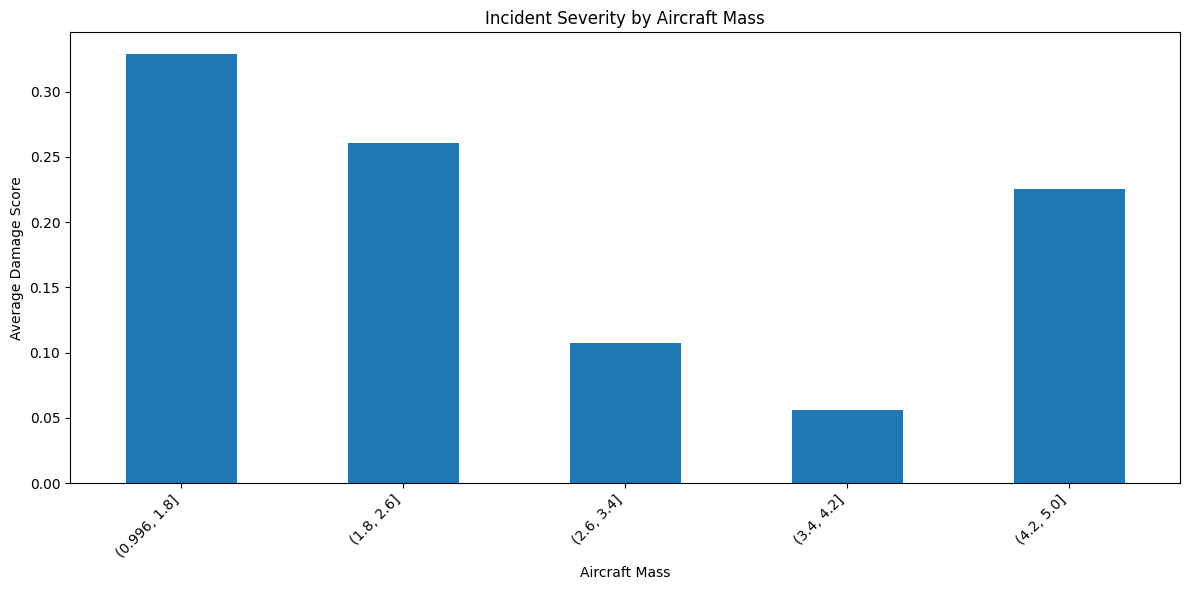

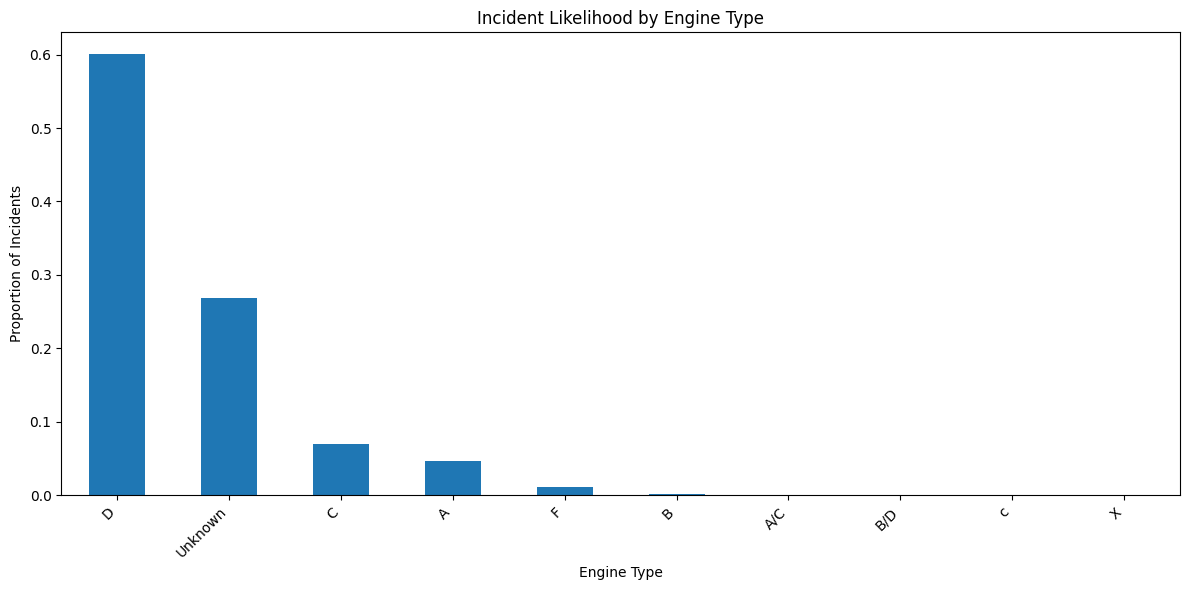

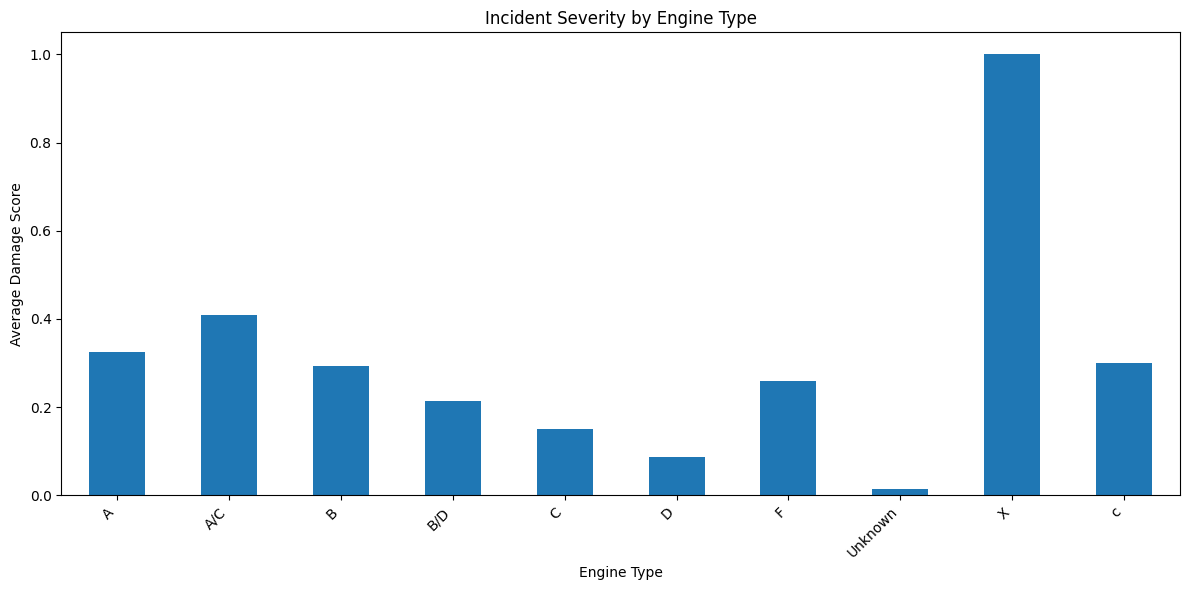

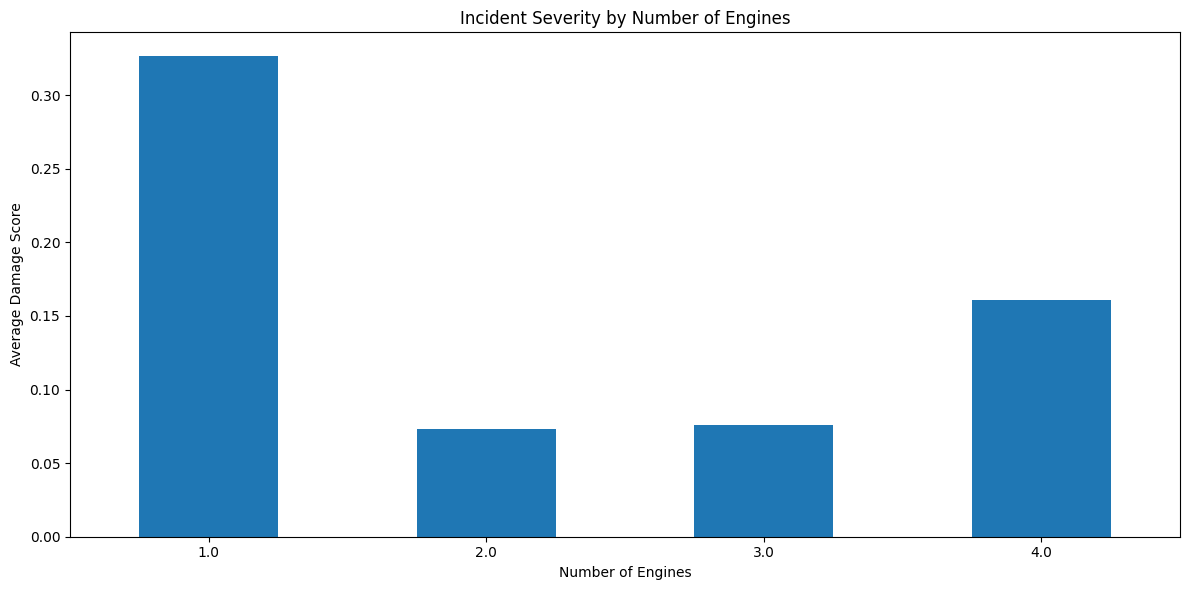

Incident Likelihood by Aircraft Mass:
Aircraft Mass
(0.996, 1.8]    0.044232
(1.8, 2.6]      0.046777
(2.6, 3.4]      0.139957
(3.4, 4.2]      0.760712
(4.2, 5.0]      0.008323
dtype: float64

Incident Severity by Aircraft Mass:
Aircraft Mass
(0.996, 1.8]    0.329048
(1.8, 2.6]      0.260560
(2.6, 3.4]      0.107194
(3.4, 4.2]      0.055677
(4.2, 5.0]      0.225673
Name: Aircraft Damage, dtype: float64

Incident Likelihood by Engine Type:
Engine Type
D          0.600222
Unknown    0.268931
C          0.069298
A          0.047368
F          0.011143
B          0.002217
A/C        0.000408
B/D        0.000350
c          0.000057
X          0.000006
Name: count, dtype: float64

Incident Severity by Engine Type:
Engine Type
A          0.323997
A/C        0.408451
B          0.292746
B/D        0.213115
C          0.149689
D          0.087540
F          0.258247
Unknown    0.014587
X          1.000000
c          0.300000
Name: Aircraft Damage, dtype: float64

Incident Severity by Number of 

In [41]:
# Analyze incident likelihood by aircraft mass
mass_bins = pd.cut(df['Aircraft Mass'], bins=5)
incident_by_mass = df.groupby(mass_bins).size()
incident_by_mass_normalized = incident_by_mass / incident_by_mass.sum()

# Analyze incident severity by aircraft mass
severity_by_mass = df.groupby(mass_bins)['Aircraft Damage'].mean()

# Analyze incident likelihood by engine type
incident_by_engine = df['Engine Type'].value_counts()
incident_by_engine_normalized = incident_by_engine / incident_by_engine.sum()

# Analyze incident severity by engine type
severity_by_engine = df.groupby('Engine Type')['Aircraft Damage'].mean()

# Correlation between number of engines and incident severity
engine_count_severity = df.groupby('Engines')['Aircraft Damage'].mean()

# Visualizations
plt.figure(figsize=(12, 6))
incident_by_mass_normalized.plot(kind='bar')
plt.title('Incident Likelihood by Aircraft Mass')
plt.xlabel('Aircraft Mass')
plt.ylabel('Proportion of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
severity_by_mass.plot(kind='bar')
plt.title('Incident Severity by Aircraft Mass')
plt.xlabel('Aircraft Mass')
plt.ylabel('Average Damage Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
incident_by_engine_normalized.plot(kind='bar')
plt.title('Incident Likelihood by Engine Type')
plt.xlabel('Engine Type')
plt.ylabel('Proportion of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
severity_by_engine.plot(kind='bar')
plt.title('Incident Severity by Engine Type')
plt.xlabel('Engine Type')
plt.ylabel('Average Damage Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
engine_count_severity.plot(kind='bar')
plt.title('Incident Severity by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Average Damage Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Incident Likelihood by Aircraft Mass:")
print(incident_by_mass_normalized)

print("\nIncident Severity by Aircraft Mass:")
print(severity_by_mass)

print("\nIncident Likelihood by Engine Type:")
print(incident_by_engine_normalized)

print("\nIncident Severity by Engine Type:")
print(severity_by_engine)

print("\nIncident Severity by Number of Engines:")
print(engine_count_severity)

# Calculate correlation between Aircraft Mass and Aircraft Damage
correlation = df['Aircraft Mass'].corr(df['Aircraft Damage'])
print(f"\nCorrelation between Aircraft Mass and Damage: {correlation:.4f}")

Key findings:

    - Medium-sized aircraft (3.4-4.2 mass units) are involved in the most incidents, but they tend to suffer less severe damage.
    - Lighter aircraft, while involved in fewer incidents, tend to suffer more severe damage when incidents occur.
    - Engine type 'D' is involved in the majority of incidents, but these incidents tend to result in less severe damage compared to other engine types.
    - Single-engine aircraft suffer the most severe damage on average, which aligns with the finding that lighter aircraft tend to experience more severe damage.
    - There's a weak negative correlation between aircraft mass and damage severity, suggesting that heavier aircraft might be slightly more resilient to wildlife strikes.

These findings could have important implications for aircraft design, wildlife management strategies at airports, and pilot training programs. 

# Conclusion :

This comprehensive analysis of wildlife strike patterns provides a solid foundation for data-driven decision-making in aviation safety. By implementing targeted strategies based on these insights, the industry can work towards significantly reducing both the frequency and impact of wildlife strikes, ultimately enhancing the safety of air travel for passengers and crew alike.